## Annotation Visualizations

### Imports & Initializations 

In [7]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

In [8]:
def tokenize(text):
    # Tokenize based on spaces while keeping track of character positions.
    tokens = []
    char_indices = []
    start = 0
    for word in text.split():
        end = start + len(word)
        tokens.append(word)
        char_indices.append((start, end))
        start = end + 1  # Assuming a single char for space
    return tokens, char_indices

def align_labels_with_tokens(char_indices, labels_range):
    # Initialize labels for each token with 'O' (no label)
    labels = ['O'] * len(char_indices)
    
    for start, end, label in labels_range:
        for i, (tok_start, tok_end) in enumerate(char_indices):
            if not (end < tok_start or start > tok_end):  # Overlap condition
                labels[i] = label
    return labels

def extract_dataset_labels(json_data):
    id_to_label = {0: 'O', 1: 'Organization', 2: 'O', 3: 'Person', 4: 'Person', 5: 'Location', 6: 'Organization', 7: 'O', 8: 'Location'}
    
    test_labels = {}
    labels = {}
    label_path = os.path.join( "data", "conll2003", "dataset", "test.json")

    with open(label_path, "r") as f:
        for line in f:
            # Each line is a separate JSON object
            json_line = json.loads(line)
            text = ""
            for word in json_line["tokens"]:
                if word == "-LPR-":
                    word = "("
                elif word == "-RPR-":
                    word = ")"
                text += word + " "
            test_labels[text.strip()] = json_line["tags"]
            
    for task in json_data["tasks"]:
        text = task["data"]["text"].strip()
        if text in list(test_labels.keys()):
            label = []
            for _label in test_labels[text]:
                label.append(id_to_label[_label])
            labels[text] = label
    return labels

def extract_model_labels(json_data):
    labels = {}
    for task in json_data["tasks"]:
        text = task["data"]["text"]
        tokens, char_indices = tokenize(text)
        pred_ranges = [(r["value"]["start"], r["value"]["end"], r["value"]["labels"][0]) for p in task["predictions"] for r in p["result"]]
        pred_labels = align_labels_with_tokens(char_indices, pred_ranges)
        labels[text.strip()] = pred_labels
    return labels

def extract_annotations_labels(json_data):
    labels = {}
    for task in json_data["tasks"]:
        text = task["data"]["text"]
        tokens, char_indices = tokenize(text)
        anno_ranges = [(r["value"]["start"], r["value"]["end"], r["value"]["labels"][0]) for a in task["annotations"] for r in a["result"]]
        anno_labels = align_labels_with_tokens(char_indices, anno_ranges)
        labels[text.strip()] = anno_labels
    return labels

def extract_inital_predictions_labels(json_data):
    labels = {}
    for task in json_data["tasks"]:
        text = task["data"]["text"]
        tokens, char_indices = tokenize(text)
        pred_ranges = [(r["value"]["start"], r["value"]["end"], r["value"]["labels"][0]) for p in task["predictions"] for r in p["result"]]
        pred_labels = align_labels_with_tokens(char_indices, pred_ranges)
        labels[text.strip()] = pred_labels
    return labels

def calculate_accuracy(prediction_labels, true_labels, per_sentence=False):
    if per_sentence:
        accuracies = []
        for text in prediction_labels:
            correct = 0
            for pred, true in zip(prediction_labels[text], true_labels[text]):
                if pred == true:
                    correct += 1
            accuracies.append(correct/len(prediction_labels[text]))
        return accuracies

    else:
        correct = 0
        total = 0
        for text in prediction_labels:
            for pred, true in zip(prediction_labels[text], true_labels[text]):
                if pred == true:
                    correct += 1
                total += 1
        return correct/total
    
def plot_accuracy_bar_chart(accuracies, title):
    labels = list(accuracies.keys())
    accuracy_values = list(accuracies.values())
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, accuracy_values, color='skyblue')
    plt.title(title)
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom') # va: vertical alignment
    
    plt.show()

def plot_confusion_matrix(true_labels, predicted_labels, classes, title='Confusion matrix', cmap=plt.cm.Blues, true_label="True Label", predicted_label="Predicted Label"):
    cm = confusion_matrix(true_labels, predicted_labels, labels=classes)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # Normalization
    
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", linewidths=.5, cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel(true_label)
    plt.xlabel(predicted_label)
    plt.show()

In [9]:
trial_type = "pair"
annotation_path = os.path.join("data", f"{trial_type}", "annotations")
annotations = {}
inital_model_predictions = {}

for file in os.listdir(annotation_path):
    if file.endswith("_annotations.json"):
        with open(os.path.join(annotation_path, file), "r") as f:
            data = json.load(f)
            participant_id = str(file.split("_")[-2])
            annotations[participant_id] = data
    elif file.startswith("model_predictions"):
        with open(os.path.join(annotation_path, file), "r") as f:
            data = json.load(f)
            inital_model_predictions = data

### Accuracies

In [10]:
def results(inital_model_labels, updated_model_labels, annotation_labels, dataset_labels, participant_id, per_sentence=False):
    accuracies_dataset = {
    'Initial Model': calculate_accuracy(inital_model_labels, dataset_labels, per_sentence),
    'Updated Model': calculate_accuracy(updated_model_labels, dataset_labels, per_sentence),
    'Annotation': calculate_accuracy(annotation_labels, dataset_labels, per_sentence)
    }
    plot_accuracy_bar_chart(accuracies_dataset, f"Accuracy Comparison with respect to Dataset for Participant {participant_id}")

    accuracies_annotation = {
        'Initial Model': calculate_accuracy(inital_model_labels, annotation_labels, per_sentence),
        'Updated Model': calculate_accuracy(updated_model_labels, annotation_labels, per_sentence),
        'Dataset': calculate_accuracy(dataset_labels, annotation_labels, per_sentence)
    }
    plot_accuracy_bar_chart(accuracies_annotation, f"Accuracy Comparison with respect to Annotation for Participant {participant_id}")

    classes = ['O', 'Organization', 'Person', 'Location']

    # Intal Model Confusion Matrix with respect to Dataset
    true_labels = []
    for text in dataset_labels:
        true_labels.extend(dataset_labels[text])
    predicted_labels = []
    for text in dataset_labels:
        predicted_labels.extend(inital_model_labels[text])
    plot_confusion_matrix(true_labels, predicted_labels, classes, title=f'Initial Model Confusion Matrix for Participant {participant_id}', cmap=plt.cm.Blues, true_label="Dataset Label", predicted_label="Inital Model Label")

    # Updated Model Confusion Matrix with respect to Dataset
    predicted_labels = []
    for text in dataset_labels:
        predicted_labels.extend(updated_model_labels[text])
    plot_confusion_matrix(true_labels, predicted_labels, classes, title=f'Updated Model Confusion Matrix for Participant {participant_id}', cmap=plt.cm.Blues, true_label="Dataset Label", predicted_label="Updated Model Label")

    # Annotation Confusion Matrix with respect to Dataset
    predicted_labels = []
    for text in dataset_labels:
        predicted_labels.extend(annotation_labels[text])
    plot_confusion_matrix(true_labels, predicted_labels, classes, title=f'Annotation Confusion Matrix for Participant {participant_id}', cmap=plt.cm.Blues, true_label="Dataset Label", predicted_label="Annotation Label")

    # Intal Model Confusion Matrix with respect to Annotation
    true_labels = []
    for text in annotation_labels:
        true_labels.extend(annotation_labels[text])
    predicted_labels = []
    for text in annotation_labels:
        predicted_labels.extend(inital_model_labels[text])
    plot_confusion_matrix(true_labels, predicted_labels, classes, title=f'Initial Model Confusion Matrix for Participant {participant_id}', cmap=plt.cm.Blues, true_label="Annotation Label", predicted_label="Inital Model Label")

    # Updated Model Confusion Matrix with respect to Annotation
    predicted_labels = []
    for text in annotation_labels:
        predicted_labels.extend(updated_model_labels[text])
    plot_confusion_matrix(true_labels, predicted_labels, classes, title=f'Updated Model Confusion Matrix for Participant {participant_id}', cmap=plt.cm.Blues, true_label="Annotation Label", predicted_label="Updated Model Label")

Initial model accuracy with respect to dataset: 0.8893203883495145

Participant 001,006
Annotation accuracy with respect to dataset: 0.974757281553398
Updated model accuracy with respect to dataset: 0.8893203883495145
Updated model accuracy with respect to annotation: 0.883495145631068
Initial model accuracy with respect to annotation: 0.883495145631068



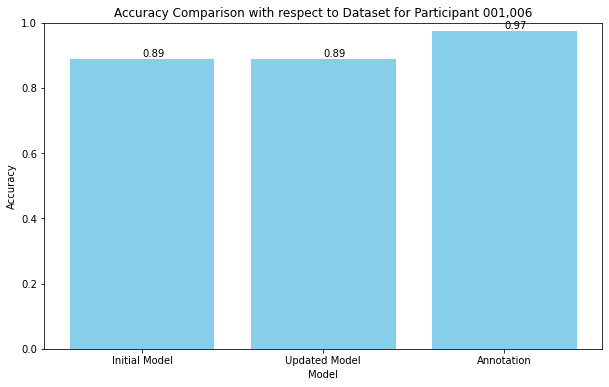

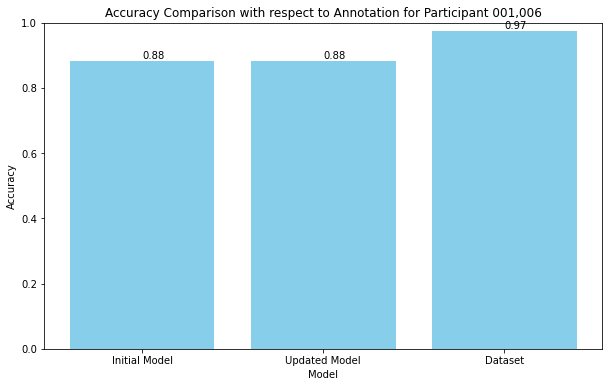

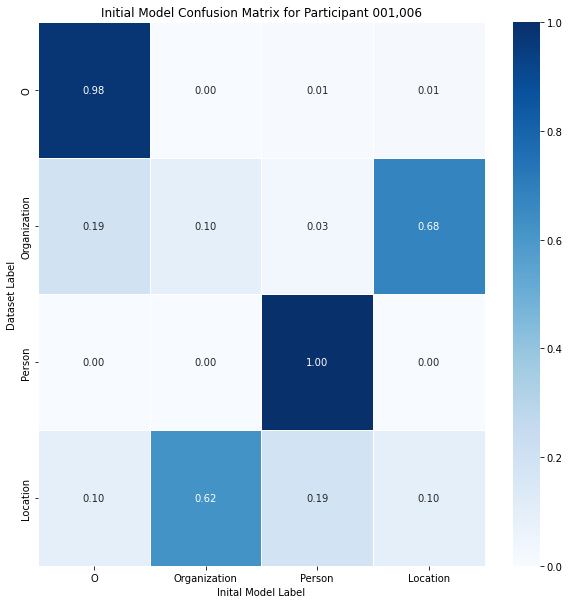

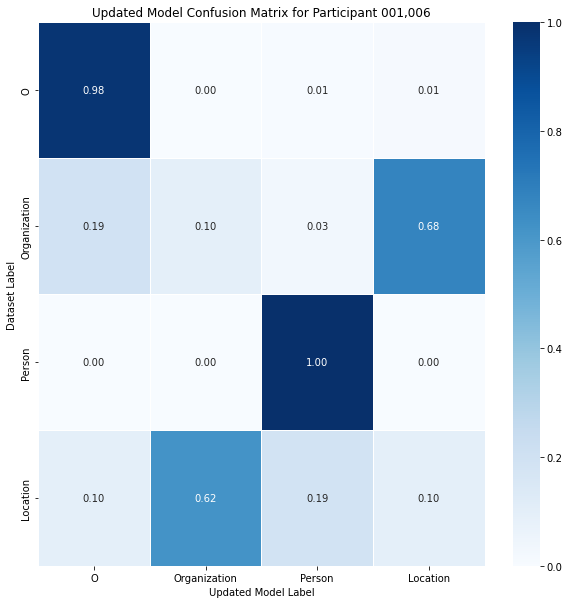

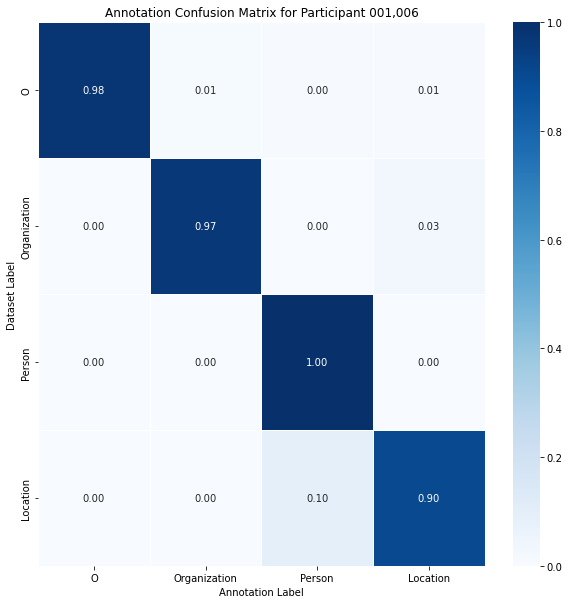

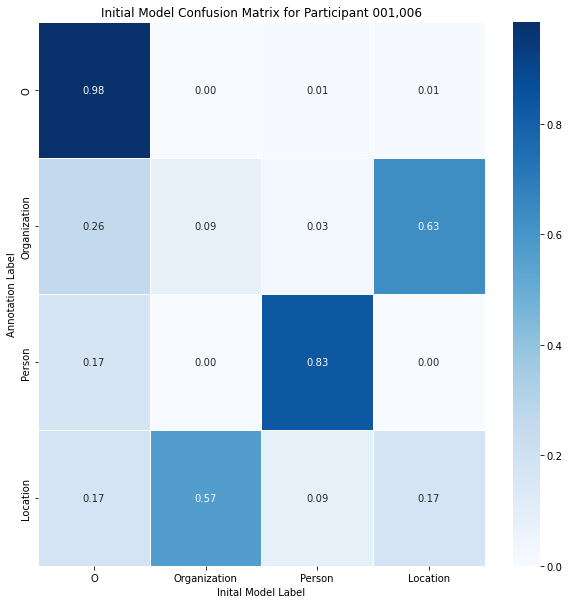

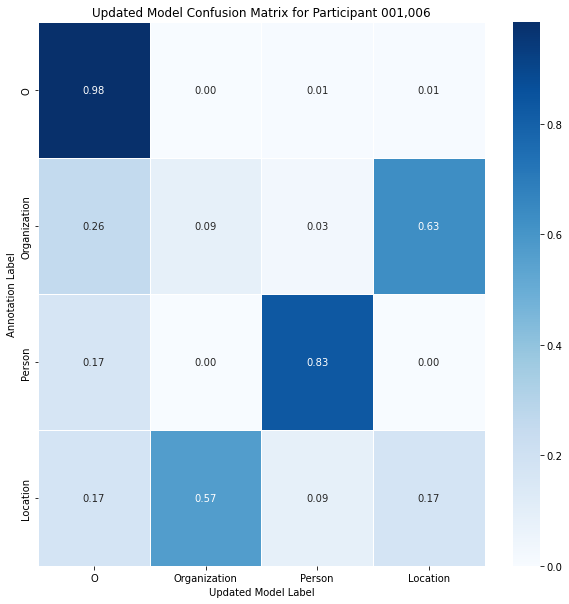

Participant 002,003
Annotation accuracy with respect to dataset: 0.9339805825242719
Updated model accuracy with respect to dataset: 0.8893203883495145
Updated model accuracy with respect to annotation: 0.8466019417475729
Initial model accuracy with respect to annotation: 0.8466019417475729



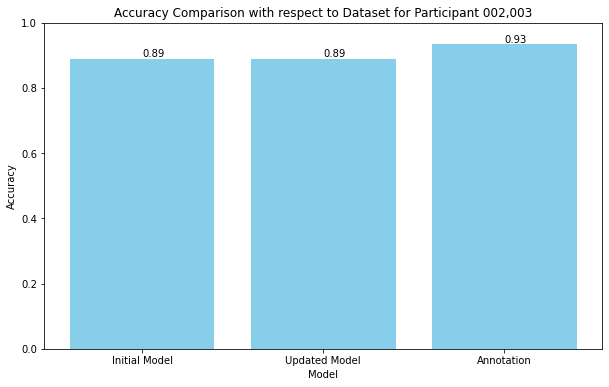

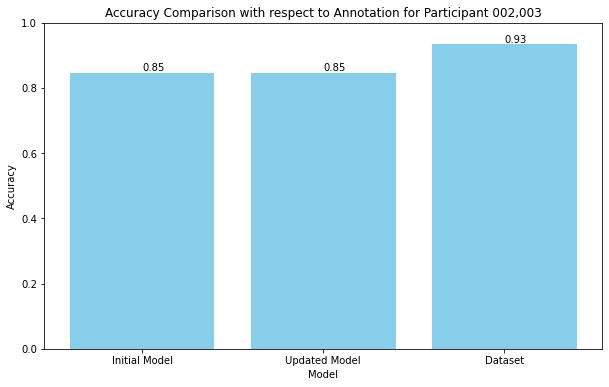

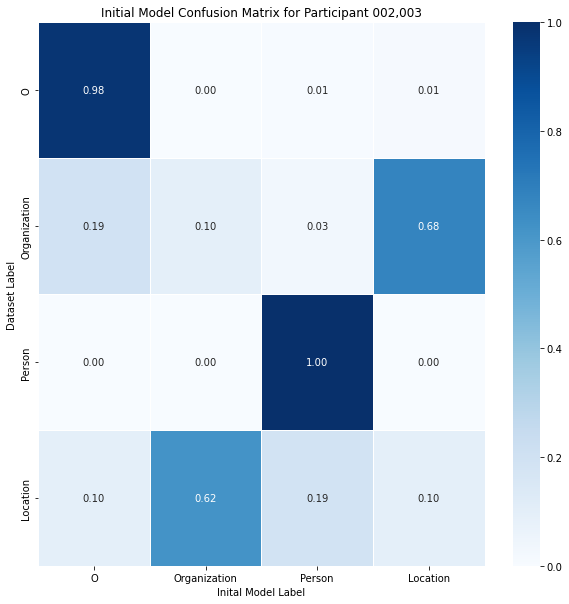

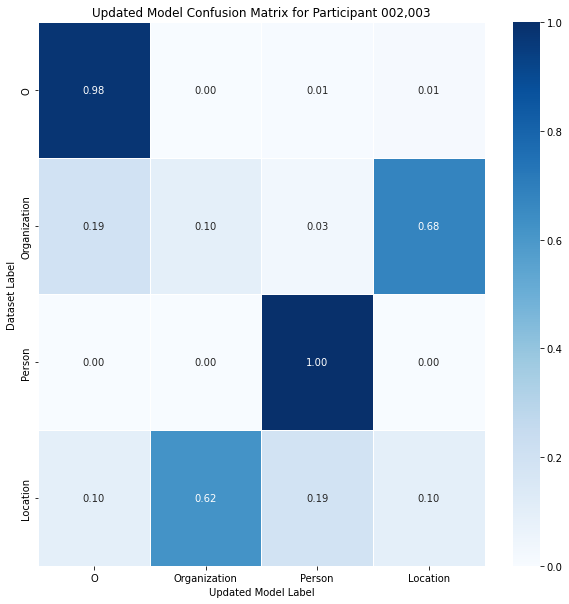

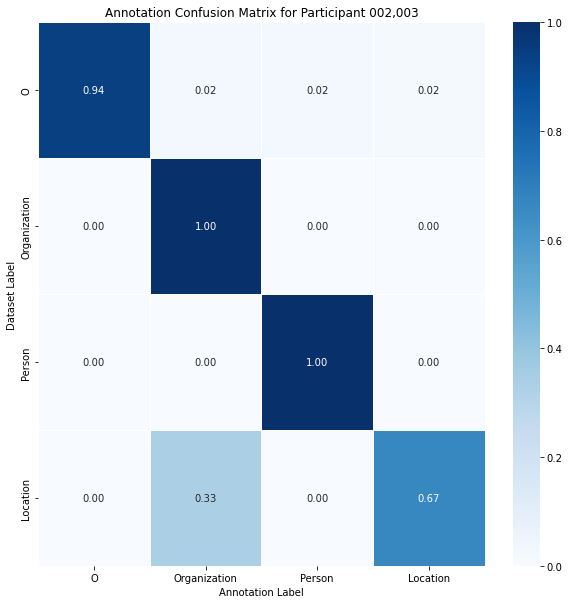

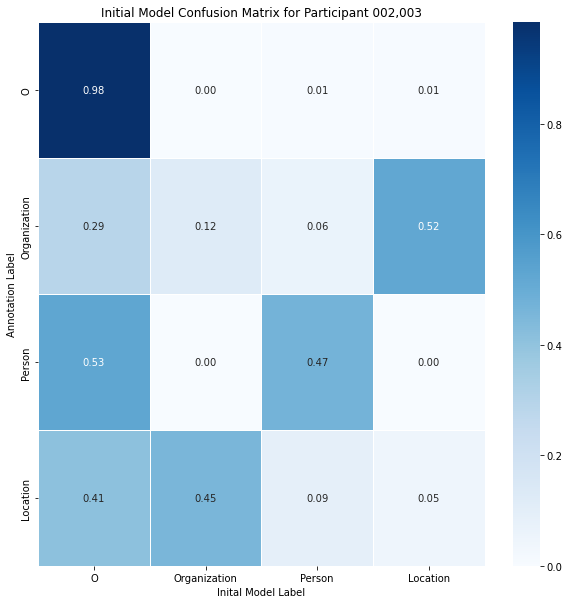

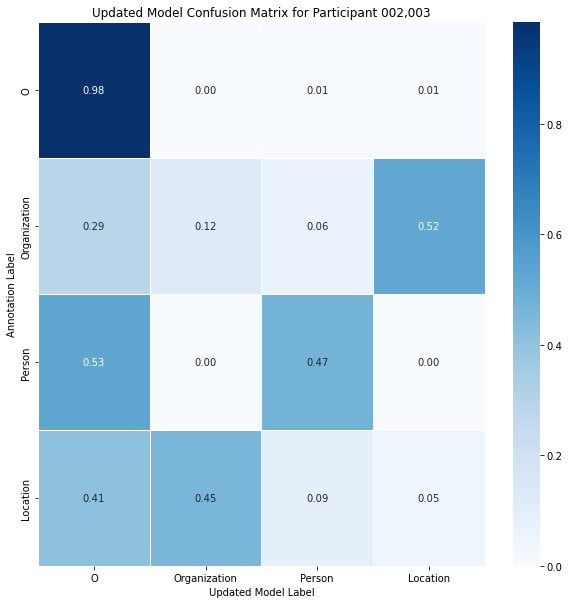

In [11]:
model_results = {}

dataset_labels = extract_dataset_labels(inital_model_predictions)
inital_model_labels = extract_model_labels(inital_model_predictions)

accuracy = calculate_accuracy(inital_model_labels, dataset_labels, per_sentence=False)
model_results["Initial model accuracy with respect to dataset"] = accuracy
print(f"Initial model accuracy with respect to dataset: {accuracy}")

print()

for participant in annotations.keys():
    print(f"Participant {participant}")
    updated_model_labels = extract_model_labels(annotations[participant])
    annotation_labels = extract_annotations_labels(annotations[participant])
    
    accuracy = calculate_accuracy(annotation_labels, dataset_labels, per_sentence=False)
    model_results[f"Annotation accuracy with respect to dataset for Participant {participant}"] = accuracy
    print(f"Annotation accuracy with respect to dataset: {accuracy}")

    accuracy = calculate_accuracy(updated_model_labels, dataset_labels, per_sentence=False)
    model_results[f"Updated model accuracy with respect to dataset for Participant {participant}"] = accuracy
    print(f"Updated model accuracy with respect to dataset: {accuracy}")
    
    accuracy = calculate_accuracy(updated_model_labels, annotation_labels, per_sentence=False)
    model_results[f"Updated model accuracy with respect to annotation for Participant {participant}"] = accuracy
    print(f"Updated model accuracy with respect to annotation: {accuracy}")
    
    accuracy = calculate_accuracy(inital_model_labels, annotation_labels, per_sentence=False)
    model_results[f"Initial model accuracy with respect to annotation for Participant {participant}"] = accuracy
    print(f"Initial model accuracy with respect to annotation: {accuracy}")
    
    print()

    results(inital_model_labels, updated_model_labels, annotation_labels, dataset_labels, participant)


In [12]:
# save results to /formatted_data
with open(os.path.join("formatted_data", f"{trial_type}_model_results.json"), "w") as f:
    json.dump(model_results, f, indent=4)

print("Results saved to /formatted_data")

Results saved to /formatted_data
